###  Connectivity in the Mentalizing Network during Social Exclusion. 
This notebook reproduces the basic analysis from the first part of the results section, which deal with the effect of social exclusion on functional connectivity.

### Import required modules

In [43]:
from __future__ import print_function, division

import  os, sys

import scipy.stats
import numpy as np
import pickle

from nilearn import plotting, image
import pandas as pd
from mne.stats import fdr_correction

import bct # if not installed try pip install bctpy

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style="ticks", font_scale=1.5)

import warnings
warnings.filterwarnings('ignore')

###  Setting up variables, files, folders

In [6]:
home_path               = '../..'

meta_analysis_file_dir  =  os.path.join(home_path,'notebooks','01_meta_analysis') # folder containing the meta-analytic maps
data_dir                =  os.path.join(home_path,'data','clean_ts') # folder containing the connectivity data for a prior network analysis
data_264_dir            =  os.path.join(home_path, 'data','clean_ts_264') # folder containing the connectivity data for analysis of Power networks

id_density_sheet        =  os.path.join(home_path, 'data','datasheets','pID_social_networks.csv') # sheet containing pID and density 
power_file              =  os.path.join(home_path, 'data','datasheets','power_coord_data.pickle') # necessary corrdinates, names etc. for 264 Power parcellation
file_first_half         =  os.path.join(home_path, 'data', 'datasheets','1sthalf.pickle') # data from 1st half - precomputed, for supplementary analysis
file_second_half        =  os.path.join(home_path, 'data', 'datasheets', '2ndhalf.pickle') # data from 2nd half - precomputed, for supplementary analysis

networks_result_df      =  os.path.join(home_path, 'data', 'datasheets','delta_connectivity_networks.csv') # output path for network-strength results - precomputed, redo if want to re-assess
connectivity_data_file  =  os.path.join(home_path, 'data', 'datasheets','connectivity_data_array.pckl') # output path for stacked connectivity matrices - precomputed, redo if want to re-assess

### Define helper functions

In [62]:

def r_to_z(r):
    '''
        fisher transform
    '''
    z=0.5*np.log((1.0+r)/(1.0-r))
    z[np.where(np.isinf(z))]=0
    z[np.where(np.isnan(z))]=0
    return z

def z_to_r(z):
    '''
        inverse transform
    '''
    return (np.exp(2.0*z) - 1)/(np.exp(2.0*z) + 1)    


   
def extract_network_means(adj):
    '''
        Calculate within network means for 
        salience and mentalizing networks
    '''
    
    salX = np.array([0,3])
    dmnX = np.array([3,10])

    sal = adj[ salX[0]:salX[1] , salX[0]:salX[1] ]
    dmn = adj[ dmnX[0]:dmnX[1] , dmnX[0]:dmnX[1] ]
    betw = adj[ (dmnX[0]):dmnX[1] , salX[0]:salX[1]  ]

    sal = sal[np.tril_indices_from(sal, k = -1)] 
    dmn = dmn[np.tril_indices_from(dmn, k = -1)] 
       
    sal_m = np.mean(sal)
    dmn_m = np.mean(dmn) 
    betwm = np.mean(betw) 
    res = np.zeros(3)
    res[0] = sal_m
    res[1] = dmn_m
    res[2] = betwm

    return res


def extract_network_means_264(adj, networks_systems_vector):
    '''
        Calculate within network connectivity strength
        for 'whole brain' (Power 264) node network
    '''
    num_networks = len(np.unique(networks_systems_vector))
    mean_result =[[0]*2 for i in range(num_networks + 1)]

    for curr_network in range(num_networks):
        curr_network_index = np.unique(networks_systems_vector)[curr_network]
        relevant_indices = np.where(networks_systems_vector == curr_network_index )[0]
        count = 0
        sum = 0
        curr_network_length = len(relevant_indices)
        for x in range(curr_network_length):
            x_index = relevant_indices[x]
            
            for y in range(x+1, curr_network_length,1):
                y_index = relevant_indices[y]
                
                curr_value = adj[x_index,y_index]
                sum = sum + curr_value
                count = count +1
        mean_result[curr_network][0] = curr_network_index
        print('sum: ' + str(sum))
        print('count: ' + str(count))

        mean_result[curr_network][1] = sum/count
        print('mean_result: ' + str(mean_result[curr_network][1] ))
        print('####next network####')
    
    # assess strenght between
    count = 0
    sum = 0
    for curr_x_node in range(len(networks_systems_vector)):
        curr_x_node_network = networks_systems_vector[curr_x_node]
        for curr_y_node in range(len(networks_systems_vector)):
            curr_y_node_network = networks_systems_vector[curr_y_node]
            if (curr_x_node_network != curr_y_node_network):
               # print('between networks')
               # print('network x' + str(curr_x_node_network))
               # print('network y' + str(curr_y_node_network))
                count = count +1
                curr_value = adj[curr_x_node, curr_y_node]
                sum = sum + curr_value
    mean_result[num_networks ][0] = 99
    mean_result[num_networks ][1] = sum/count

    return mean_result


### Meta-analytic node derivation
We use Neurosynth to derive nodes (see Neurosynth notebook for details) and plot the maps (similar to Figure 1)

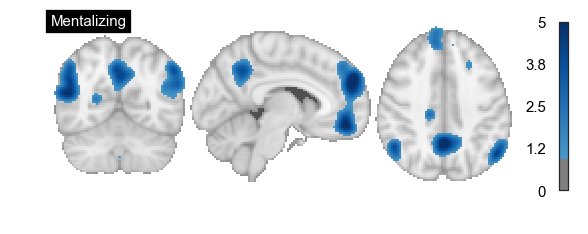

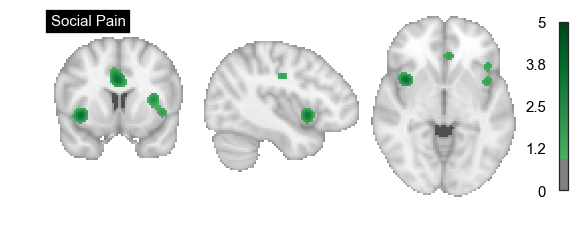

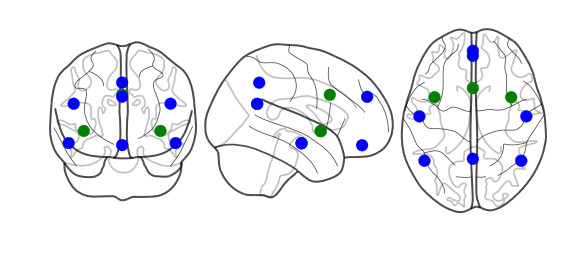

In [11]:
os.chdir(meta_analysis_file_dir)

plotting.plot_stat_map(image.smooth_img('pFgA_mentali_z_FDR_0.01.nii.gz', fwhm=8),         
                       threshold=1, title="Mentalizing", 
                       vmax =5, cmap = 'Blues', 
                       annotate = False,
                       cut_coords = [-7, -60, 40],
                       draw_cross = False);

plotting.plot_stat_map(image.smooth_img('pFgA_social_And_pain_z_FDR_0.01.nii.gz', fwhm=8), 
                       threshold=1, title="Social Pain", 
                       vmax =5, cmap = 'Greens', 
                       cut_coords = [-40, 10, -5],
                       annotate = False, 
                       draw_cross = False);

networks_coords = [ (0,16,32),    #SAL/SocialPain - dACC  #setting up networks
                    (38,7,-4),    #SAL/SocialPain - raINS
                    (-38,7,-4),   #SAL/SocialPain - laINS
                    (0,53,30),    #MENT/DMN - DMPFC
                    (0,48,-18),    #MENT/DMN - VMPFC
                    (0,-54,44),   #MENT/DMN - Precun
                    (48,-56,23),   #MENT/DMN - rTPJ
                    (-48,-56,23), #MENT/DMN - lTPJ                   
                    (53,-12,-16), #MENT/DMN - rMTG
                    (-53,-12,-16)]#MENT/DMN - lMTG
n_nodes = len(networks_coords)

networks_cols = ['green','green','green','blue','blue','blue','blue','blue','blue', 'blue']
node_sizes =  np.array([7,7,7,7,7,7,7,7,7,7])                
networks_labels = ['dACC_SP', 'raINS_SP', 'laINS_SP', 'DMPFC_Men', 'VMPFC_Men', 'Precun_Men', 'rTPJ_Men', 'lTPJ_Men', 'rMTG_Men', 'lMTG_Men']

fig = plt.figure(figsize = (7,3));
plotting.plot_connectome(np.zeros((n_nodes,n_nodes)), networks_coords, 
                         node_size = node_sizes*20, node_color= networks_cols, 
                         annotate = False, figure = fig);

#### Read in extracted connectivity matrices
Here we read in the connectivity matrices for social inclusion and social exclusion, and visualize average connectivity. (see extraction-notebook for details)

In [26]:
df = pd.read_csv(id_density_sheet)
subjects = df.pID
subjects = [s +  'TS_Fair_Unfair_CorrelationMat.npz' for s in subjects]
n_subjs = len(subjects)
print('Number of subjects: ' + str(n_subjs))

res_list = []
res_array = np.zeros((2, n_nodes, n_nodes, n_subjs))
for s in range(n_subjs):
    curr_file = subjects[s]
    path_to_load = os.path.join(data_dir, curr_file)
    data_array = np.load(path_to_load)['arr_2']
    res_list.append(data_array)
    res_array[:,:,:, s] = r_to_z(data_array) #Fisher to make more gaussian
    del data_array

mean_correlations = np.mean(res_array, axis=3)
mean_correlations = z_to_r(mean_correlations)  #Inverse fisher transform to convert back to r
mean_connect_fair = pd.DataFrame(mean_correlations[0,:,:], index=networks_labels, columns = networks_labels)
mean_connect_unfair = pd.DataFrame(mean_correlations[1,:,:], index=networks_labels, columns = networks_labels)
mean_connect_unfair_less_fair = mean_connect_unfair - mean_connect_fair


# comment/uncomment to overwrite pre-packaged results
#with open(connectivity_data_file, 'w') as f:   
#    pickle.dump([res_array, subjects], f)

Number of subjects: 80


#### Plotting the average connectivity (Figure 2).

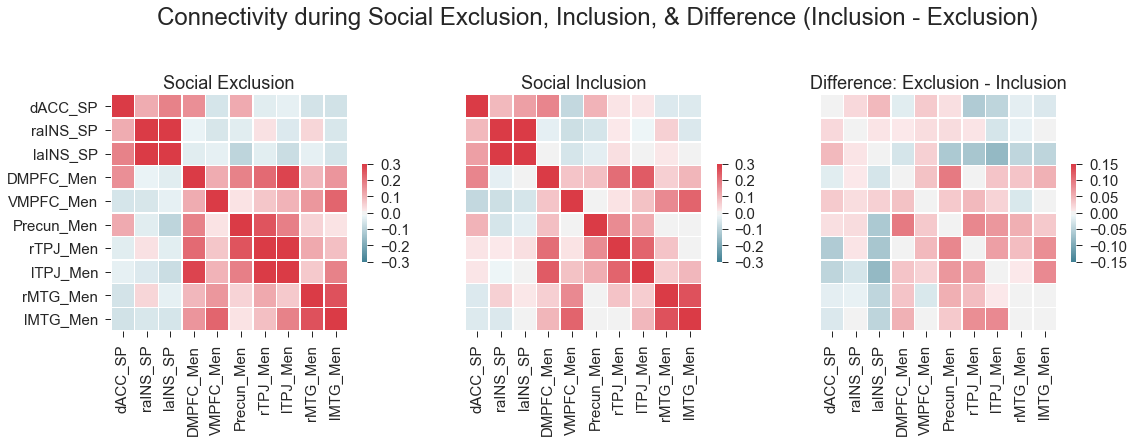

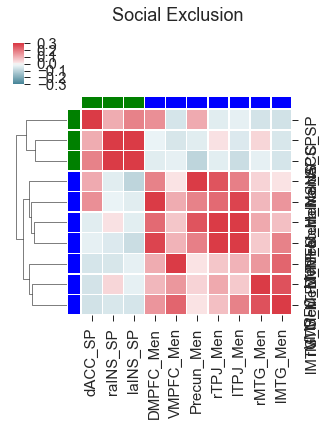

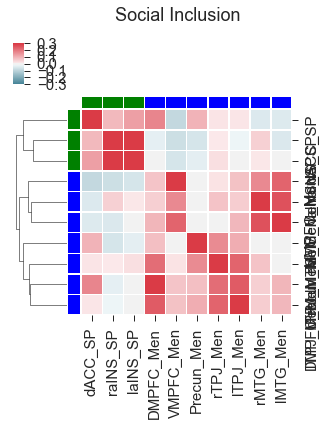

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))
fig.suptitle('Connectivity during Social Exclusion, Inclusion, & Difference (Inclusion - Exclusion)', fontsize=24)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.zeros_like(mean_connect_fair, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(mean_connect_unfair,  cmap=cmap, vmax=.3, vmin = -.3, annot = False,
                square=True, xticklabels=networks_labels, yticklabels=networks_labels, 
                linewidths=.5, cbar_kws={"shrink": .3}, ax=ax1)
ax1.set_title('Social Exclusion')
 
sns.heatmap(mean_connect_fair, cmap=cmap, vmax=.3, vmin = -.3, annot = False,
                square=True, xticklabels=networks_labels, yticklabels=[], 
                linewidths=.5, cbar_kws={"shrink": .3}, ax=ax2)
ax2.set_title('Social Inclusion')

difference = mean_connect_unfair - mean_connect_fair
sns.heatmap(mean_connect_unfair_less_fair,cmap=cmap, vmax=.15, vmin = -.15, annot = False,
                square=True, xticklabels=networks_labels, yticklabels=[], 
                linewidths=.5, cbar_kws={"shrink": .3}, ax=ax3)
ax3.set_title('Difference: Exclusion - Inclusion')
plt.show()


g = sns.clustermap(mean_connect_unfair, row_colors=networks_cols, linewidths=.5,
                    col_colors=networks_cols, col_cluster=False, row_cluster=True, 
                    cmap=cmap,  vmax=.3, vmin = -.3, figsize= (5,5));
plt.suptitle('            Social Exclusion', fontsize=18);

g = sns.clustermap(mean_connect_fair, row_colors=networks_cols, linewidths=.5,
                    col_colors=networks_cols, col_cluster=False, row_cluster=True, 
                    cmap=cmap,  vmax=.3, vmin = -.3, figsize= (5,5));
plt.suptitle('            Social Inclusion', fontsize=18);

#### Extracting network strength measure
We extract the average network-wise (i.e. for social pain, for mentalizing, and for across-networks) connectivity, i.e. the average of the weighted correlations within each network. This is done for every subject, then a simple t-test is computed. 

In [30]:
fair_stats = np.zeros((n_subjs, 3))
unfair_stats = np.zeros((n_subjs, 3))
diff_stats = np.zeros((n_subjs, 3))

for curr_sub in range(n_subjs):
    curr_adj_fair = res_array[0,:,:,curr_sub]
    fair_stats[curr_sub, :] = extract_network_means(curr_adj_fair).T  #this function currently only works with numpy - give sal, dmn, cross-network values

    curr_adj_unfair = res_array[1,:,:,curr_sub]
    unfair_stats[curr_sub, :] = extract_network_means(curr_adj_unfair).T

    curr_adj_diff = curr_adj_unfair - curr_adj_fair
    diff_stats[curr_sub, :] = extract_network_means(curr_adj_diff).T
    
fs_m =  z_to_r(np.mean(fair_stats, axis = 0))  # Convert fisherized values back to r-values 
ufs_m = z_to_r(np.mean(unfair_stats, axis = 0))
d_m =   z_to_r(np.mean(diff_stats, axis = 0))

df = pd.DataFrame(index=np.zeros(6*n_subjs), 
                  columns=['ID','Condition', 'Subnetwork', 'Connectivity'])
df = df.fillna(0) # with 0s rather than NaNs

for sub in range(0,(6*n_subjs),6):
    df.ix[sub,0] = sub/6  
    df.ix[sub,1] = 'inclusion'  
    df.ix[sub,2] = 'Social Pain'
    df.ix[sub,3] = fair_stats[int(sub/6),0]
    
    df.ix[sub+1,0] = sub/6  
    df.ix[sub+1,1] = 'inclusion'  
    df.ix[sub+1,2] = 'Mentalizing'
    df.ix[sub+1,3] = fair_stats[int(sub/6),1]    
    
    df.ix[sub+2,0] = sub/6  
    df.ix[sub+2,1] = 'inclusion'  
    df.ix[sub+2,2] = 'Between Subnetworks'
    df.ix[sub+2,3] = fair_stats[int(sub/6),2]     
    ##########
    df.ix[sub+3,0] = sub/6  
    df.ix[sub+3,1] = 'exclusion'  
    df.ix[sub+3,2] = 'Social Pain'
    df.ix[sub+3,3] = unfair_stats[int(sub/6),0]
    
    df.ix[sub+4,0] = sub/6  
    df.ix[sub+4,1] = 'exclusion'  
    df.ix[sub+4,2] = 'Mentalizing'
    df.ix[sub+4,3] = unfair_stats[int(sub/6),1]    
    
    df.ix[sub+5,0] = sub/6  
    df.ix[sub+5,1] = 'exclusion'  #
    df.ix[sub+5,2] = 'Between Subnetworks'
    df.ix[sub+5,3] = unfair_stats[int(sub/6),2]  

#create the dataframes to hold these data for later use
subjects_list = [s.replace('TS_Fair_Unfair_CorrelationMat.npz','')  for s in subjects]
df_inclusion = pd.DataFrame(data=fair_stats, index= subjects_list, columns= ['SocialPain', 'Mentalizing', 'BetweenNetworks'])
df_exclusion = pd.DataFrame(data=unfair_stats, index= subjects_list, columns= ['SocialPain', 'Mentalizing', 'BetweenNetworks'])
df_conn = df_exclusion - df_inclusion
df_conn[['SP_I','Ment_I', 'Across_I']] = df_inclusion[['SocialPain', 'Mentalizing', 'BetweenNetworks']]
df_conn[['SP_E','Ment_E', 'Across_E']] = df_exclusion[['SocialPain', 'Mentalizing', 'BetweenNetworks']]
   
df_conn.to_csv(networks_result_df, sep=',')  #comment/uncomment this to overwrite pre-packaged results

#### Plotting the network strengths (Figure 3)

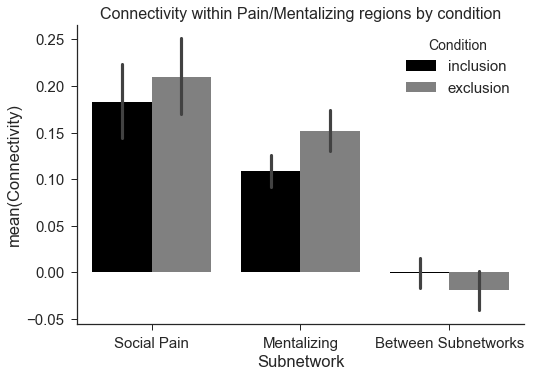

In [31]:
g = sns.barplot(y='Connectivity', x='Subnetwork', hue="Condition", data=df,
                 palette={"inclusion": "black", "exclusion": "gray"});
sns.despine()
sns.plt.title('Connectivity within Pain/Mentalizing regions by condition', fontsize = 16);

####  Statistically assess the differences

In [32]:
t_value, p_value = scipy.stats.ttest_rel(unfair_stats[:,1], fair_stats[:,1])
print("Mentalizing t={}, p={}".format(round(t_value,2), round(p_value,5)))

t_value, p_value = scipy.stats.ttest_rel(unfair_stats[:,0], fair_stats[:,0])
print("Social Pain t={}, p={}".format(round(t_value,2), round(p_value,5)))

t_value, p_value = scipy.stats.ttest_rel(unfair_stats[:,2], fair_stats[:,2])
print("Across networks t={}, p={}".format(round(t_value,2), round(p_value,5)))

Mentalizing t=3.67, p=0.00043
Social Pain t=1.23, p=0.22274
Across networks t=-1.37, p=0.17432


#### Supplementary analysis: 1st vs. 2nd half of inclusion/exclusion (Figure S1)

Statistics 1st half:
Social Pain t=1.02, p=0.31
Mentalizing t=2.23, p=0.029
Across t=-1.23, p=0.221

Statistics 2nd half:
Social Pain t=0.25, p=0.803
Mentalizing t=2.57, p=0.012
Across t=-1.32, p=0.19


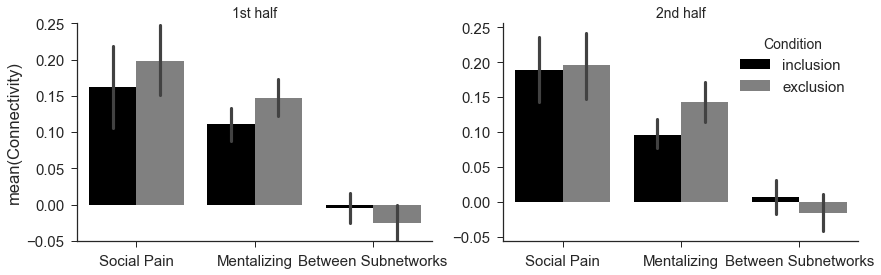

In [33]:
# 1st half
print('Statistics 1st half:')
nets = ['Social Pain','Mentalizing','Across']

with open(file_first_half) as f:  
    fair_stats1, unfair_stats1, df_conn1 = pickle.load(f)
    
for it in range(3):
    t_value, p_value = scipy.stats.ttest_rel(unfair_stats1[:,it], fair_stats1[:,it])
    print(nets[it] +" t={}, p={}".format(round(t_value,2), round(p_value,3)))

    
# 2nd half
print('\nStatistics 2nd half:')
with open(file_second_half) as f:  
    fair_stats2, unfair_stats2, df_conn2 = pickle.load(f)
    
for it in range(3):
    t_value, p_value = scipy.stats.ttest_rel(unfair_stats2[:,it], fair_stats2[:,it])
    print(nets[it] +" t={}, p={}".format(round(t_value,2), round(p_value,3)))
    
    
# Plot Figure S2 with same scheme as Figure 3
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
g = sns.barplot(y='Connectivity', x='Subnetwork', 
                data=df_conn1,
                hue="Condition", 
                palette={"inclusion": "black", "exclusion": "gray"}, 
                #legend = False,
                ax = ax1);
ax1.set_title('1st half', fontsize = 14);
ax1.set_ylim((-.05, 0.25))
ax1.legend_.remove()

ax1.set_xlabel('')


g = sns.barplot(y='Connectivity', x='Subnetwork', 
                data=df_conn2,
                hue="Condition", 
                palette={"inclusion": "black", "exclusion": "gray"},
                ax=ax2);
ax2.set_ylabel('')
ax2.set_xlabel('')

ax2.set_title('2nd half', fontsize = 14);
sns.despine()
fig.savefig('Figure_S2.pdf', dpi=600, format='pdf')

#### Additional reviewer request: compare first and second half for each network

In [34]:
print(nets[1])
dmn_unfair_first = unfair_stats1[:,1]
dmn_unfair_second = unfair_stats2[:,1]
t_value, p_value = scipy.stats.ttest_rel(dmn_unfair_first, dmn_unfair_second)
print("Connectivity Mentalizing during Exclusion: first vs. second half t={}, p={}".format(round(t_value,2), round(p_value,3)))

dmn_fair_first = fair_stats1[:,1]
dmn_fair_second = fair_stats2[:,1]
t_value, p_value = scipy.stats.ttest_rel(dmn_fair_first, dmn_fair_second)
print("Connectivity Mentalizing during Inclusion: first vs. second half t={}, p={}".format(round(t_value,2), round(p_value,3)))


Mentalizing
Connectivity Mentalizing during Exclusion: first vs. second half t=0.24, p=0.812
Connectivity Mentalizing during Inclusion: first vs. second half t=0.94, p=0.348


#### Analysis of edge-wise results (exploratory)

In [35]:
fair_corrs = np.zeros((n_nodes, n_nodes, n_subjs));
unfair_corrs = np.zeros((n_nodes, n_nodes, n_subjs));

for s in range(n_subjs):
    fair_corrs[:,:,s] = res_array[0,:,:,s]
    unfair_corrs[:,:,s] = res_array[1,:,:,s]

edge_t_results = np.zeros((fair_corrs.shape[0], fair_corrs.shape[1]))
edge_p_results = np.zeros((fair_corrs.shape[0], fair_corrs.shape[1]))

for x in range(fair_corrs.shape[0]):
    for y in range(fair_corrs.shape[1]):
        current_edge_fair = fair_corrs[x, y, :]
        current_edge_unfair = unfair_corrs[x, y, :]
        
        t, p = scipy.stats.ttest_rel(current_edge_fair, current_edge_unfair)
        edge_t_results[x,y] = t
        edge_p_results[x,y] = p  
        
edges_to_plot = np.where(edge_p_results<0.05,1,0)
for x in range(fair_corrs.shape[0]):
    for y in range(fair_corrs.shape[0]):
        if edges_to_plot[x,y] > 0:
            if edge_t_results[x,y] <0:
                edges_to_plot[x,y] = -1;
            

#### Plotting the results (Supplementary Figure S2)

In [36]:
edges_to_plot

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0, -1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, -1,  0,  1, -1, -1,  0,  0],
       [ 0,  0,  0,  0,  0, -1,  0, -1,  0, -1],
       [ 0,  0,  1,  0,  0, -1, -1,  0,  0, -1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, -1, -1,  0,  0]])

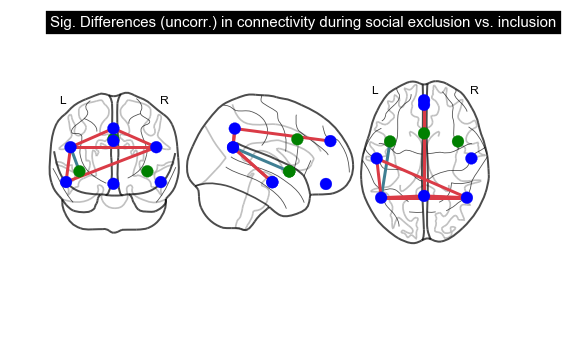

In [37]:
fig = plt.figure()
ax1 = plt.subplot(111)
plotting.plot_connectome((edges_to_plot * (-1)), 
                         networks_coords, 
                         node_size = node_sizes*20, 
                         edge_cmap = cmap,  
                         node_color= networks_cols, 
                         title="Sig. Differences (uncorr.) in connectivity during social exclusion vs. inclusion",
                         axes = ax1);
fig.savefig('Figure_S1.pdf')

#### Connectivity during social exclusion in  large-scale networks

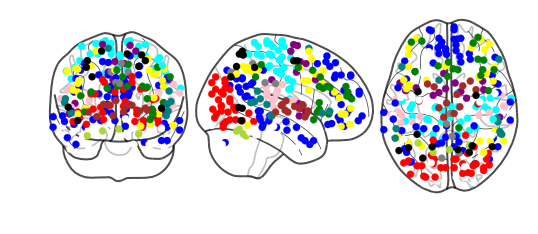

In [38]:
# Setting up the networks and plot node locations
with open(power_file) as f:  
    networks_coords, networks_cols, networks_systems, networks_systems_names, networks_systems_numbers, networks_labels, power, atlas, n_nodes_power  = pickle.load(f)
    
fig = plt.figure(figsize = (7,3))  
plotting.plot_connectome(np.zeros((n_nodes_power, n_nodes_power)), 
                         networks_coords, 
                         annotate = False,
                         display_mode = 'ortho',
                         node_color = networks_cols); 

#### Read in extracted connectivity matrices
same code as above, other data

In [44]:
df = pd.read_csv(id_density_sheet)
subjects = df.pID
subjects = [s +  'TS_Fair_Unfair_CorrelationMat_264.npz' for s in subjects]
n_subjs = len(subjects)
print('Number of subjects: ' + str(n_subjs))

res_list = []
res_array = np.zeros((2,n_nodes_power, n_nodes_power, n_subjs))
for s in range(n_subjs):
    path_to_load = os.path.join(data_264_dir, subjects[s])
    data_array = np.load(path_to_load)['arr_2']
    res_list.append(data_array)
    res_array[:,:,:, s] = r_to_z(data_array) #fisher z-transform data

mean_correlations = np.mean(res_array, axis=3)
mean_connect_fair = pd.DataFrame(mean_correlations[0,:,:], index=networks_labels, columns = networks_labels)
mean_connect_unfair = pd.DataFrame(mean_correlations[1,:,:], index=networks_labels, columns = networks_labels)

Number of subjects: 80


#### Plot the average connectivity matrices

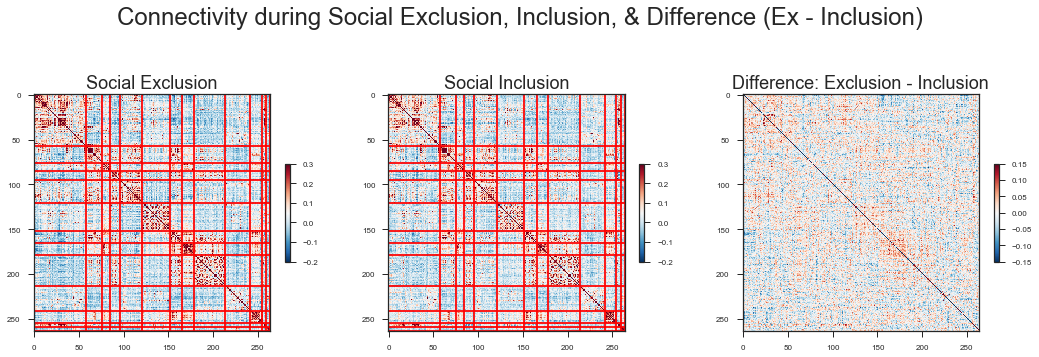

In [45]:
bounds,ixes=bct.grid_communities(networks_systems_numbers.astype('int'))       

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6), facecolor='white')
fig.suptitle('Connectivity during Social Exclusion, Inclusion, & Difference (Ex - Inclusion)', fontsize=24)
myarray = np.asarray(mean_connect_unfair)
im= ax1.imshow(myarray[np.ix_(ixes,ixes)],interpolation='none',cmap='RdBu_r', vmin = -0.2, vmax = 0.3);
for b in bounds:
      ax1.axvline(x=b,color='red')
      ax1.axhline(y=b,color='red')
ax1.grid(False);
ax1.tick_params(axis='x', labelsize=8)
ax1.tick_params(axis='y', labelsize=8)
cbar = plt.colorbar(im, ax = ax1, shrink = 0.3)#, ticks=4)
cbar.ax.tick_params(labelsize=8) 
#pls()
ax1.set_title('Social Exclusion')
 
myarray = np.asarray(mean_connect_fair)
im= ax2.imshow(myarray[np.ix_(ixes,ixes)],interpolation='none',cmap='RdBu_r', vmin = -0.2, vmax = 0.3);
for b in bounds:
      ax2.axvline(x=b,color='red')
      ax2.axhline(y=b,color='red')
ax2.grid(False);
ax2.tick_params(axis='x', labelsize=8)
ax2.tick_params(axis='y', labelsize=8)
cbar = plt.colorbar(im, ax = ax2, shrink = 0.3)#, ticks=4)
cbar.ax.tick_params(labelsize=8)       
ax2.set_title('Social Inclusion')

difference = mean_connect_unfair - mean_connect_fair
myarray = np.asarray(difference)
im= ax3.imshow(myarray[np.ix_(ixes,ixes)],interpolation='none',cmap='RdBu_r', vmin = -0.15, vmax = 0.15);
#for b in bounds:
#      ax3.axvline(x=b,color='red')
#      ax3.axhline(y=b,color='red')
ax3.grid(False);
ax3.tick_params(axis='x', labelsize=8)
ax3.tick_params(axis='y', labelsize=8)
cbar = plt.colorbar(im, ax = ax3, shrink = 0.3)#, ticks=4)
cbar.ax.tick_params(labelsize=8)        
ax3.set_title('Difference: Exclusion - Inclusion')

#### Extracting network strength measure for large-scale networks
Analogously to the analysis for smaller networks, also extract strength for the large-scale systems

In [53]:
n_networks = len(np.unique(networks_systems_numbers))

fair_stats = np.zeros((n_subjs, n_networks+1))
unfair_stats = np.zeros((n_subjs, n_networks+1))
diff_stats = np.zeros((n_subjs, n_networks+1))

for curr_sub in range(n_subjs):
    curr_adj_fair = res_array[0,:,:,curr_sub]
    curr_result = extract_network_means_264(curr_adj_fair, networks_systems_numbers);
    curr_result_array = np.asarray(curr_result) 
    fair_stats[curr_sub, :] = curr_result_array[:,1].T
    
    curr_adj_unfair = res_array[1,:,:,curr_sub]
    curr_result = extract_network_means_264(curr_adj_unfair, networks_systems_numbers);
    curr_result_array = np.asarray(curr_result) 
    unfair_stats[curr_sub, :] = curr_result_array[:,1].T
    
    curr_adj_diff = curr_adj_unfair - curr_adj_fair
    curr_result = extract_network_means_264(curr_adj_diff, networks_systems_numbers);
    curr_result_array = np.asarray(curr_result) 
    diff_stats[curr_sub, :] = curr_result_array[:,1].T
    
fs_m =  np.mean(fair_stats, axis = 0)
ufs_m = np.mean(unfair_stats, axis = 0)
d_m =   np.mean(diff_stats, axis = 0)


sum: 220.308419404
count: 1653
mean_result: 0.133277930674
####next network####
sum: 27.3080378987
count: 153
mean_result: 0.178483907834
####next network####
sum: 7.04734414091
count: 36
mean_result: 0.19575955947
####next network####
sum: 2.00137476586
count: 55
mean_result: 0.0363886321066
####next network####
sum: 34.0466207871
count: 300
mean_result: 0.113488735957
####next network####
sum: 24.951720556
count: 465
mean_result: 0.0536596140989
####next network####
sum: 2.30673896227
count: 91
mean_result: 0.0253487798051
####next network####
sum: 7.74456855671
count: 78
mean_result: 0.0992893404707
####next network####
sum: 61.1627864354
count: 595
mean_result: 0.102794599051
####next network####
sum: 6.75022819323
count: 378
mean_result: 0.0178577465429
####next network####
sum: 18.5667362558
count: 78
mean_result: 0.238035080202
####next network####
sum: 4.31963174475
count: 10
mean_result: 0.431963174475
####next network####
sum: 0.662369528931
count: 6
mean_result: 0.1103949214

In [54]:
n = (n_networks+1)
index = np.zeros(n * n_subjs *2)
columns = ['ID','Condition', 'Subnetwork', 'Connectivity']

df = pd.DataFrame(index=index, columns=columns)
df = df.fillna(0) # with 0s rather than NaNs

for sub in range(0,(2*n*n_subjs),2*n):
    #print(sub)
    for net in range (n):
        df.ix[(sub)+net,0] = sub/(2*n) +1 #
        df.ix[(sub)+net,1] = 'social inclusion'  #
        df.ix[(sub)+net,2] = networks_systems_names[net]#curr_result_array[net][0]
        df.ix[(sub)+net,3] = fair_stats[int(sub/(2*n)),net]
        #print(fair_stats[(sub/(2*n)),net])

        df.ix[(sub)+n+net,0] = sub/(2*n) +1#
        df.ix[(sub)+n+net,1] = 'social exclusion'  #
        df.ix[(sub)+n+net,2] = networks_systems_names[net]#curr_result_array[net][0]
        df.ix[(sub)+n+net,3] = unfair_stats[int(sub/(2*n)),net]

####  Statistically assess the differences

In [55]:
n_p_vals = np.zeros((n_networks+1))
for curr_net in range (n_networks+1):
      t_value, p_value = scipy.stats.ttest_rel(unfair_stats[:,curr_net], fair_stats[:,curr_net])
      n_p_vals[curr_net] = p_value
      if (p_value < 0.05):
          print(networks_systems_names[curr_net])# + ": t={}, p={}".format(round(t_value,2), round(p_value,2)))  
      # note that the network labels are often quite misleading - need to look at location to make sense

alpha = 0.05 #nothing left
#alpha = 0.1 # dmn and "auditory" survive - but q=0.05 is our a-prior threshold 
reject_fdr, pval_fdr = fdr_correction(n_p_vals, alpha=alpha, method='indep')
print(reject_fdr.tolist())

DMN
Visual
CingOp
Auditory
Across
[False, False, False, False, False, False, False, False, False, False, False, False, False, False]


In [56]:
print(networks_systems_names[1])
print(n_p_vals[1])

Salience
0.390856521805


#### Create the barplot

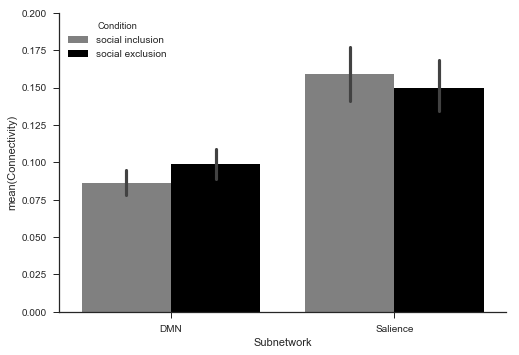

In [57]:
df2 = df.loc[df['Subnetwork'].isin(['Salience', 'DMN'])]

f = plt.figure()
sns.set(style="ticks", font_scale=1)
g = sns.barplot(y='Connectivity', 
                x='Subnetwork', 
                hue="Condition", 
                data=df2, 
                ci = 95, 
                order=['DMN', 'Salience'],
                palette={"social inclusion": "gray", "social exclusion": "black"});
g.set_ylim((0, 0.2))
g.set_xticklabels(networks_systems_names, rotation = 0)
sns.despine()